## 1. 모듈 및 분석 환경 설정

### 1-1. 모듈 불러오기

In [7]:
####### 모듈 불러오기
import torch
# 딥러닝 네트워크의 기본 구성 요소를 포함한 모듈
import torch.nn as nn
# 딥러닝에 자주 사용되는 함수가 포함된 모듈
import torch.nn.functional as F
# 가중치 추정에 필요한 최적화 알고리즘을 포함한 모듈
import torch.optim as optim
# torchvision 모듈은 딥러닝에서 자주 사용되는 데이터셋과 모델 구조 및 이미지 변환 기술을 포함
from torchvision import datasets, transforms

# 데이터와 차트의 시각화를 돕는 matplotlib
from matplotlib import pyplot as plt
# 주피터 노트북 사용자는 코드 실행 시 브라우저에서 바로 그림을 보려면 꼭 필요한 코드
# %matplotlib inline

### 1-2. 분석 환경 설정

In [2]:
# is_cuda = torch.cuda.is_available()
# device  = torch.device('cuda' if is_cuda else 'cpu')

# Mac
device = "mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cpu"

print('Current cuda device is', device)

Current cuda device is mps


### 1-3. Hyper Parameter 지정

In [3]:
# 모델 가중치를 한 번 업데이트시킬 때 사용되는 샘플 단위 개수
batch_size = 50
# 학습 데이터를 모두 사용하여 학습하는 기본 단위 횟수
epoch_num = 15
# 가중치 업데이트 정도 (학습률)
learning_rate = 0.0001

## 2. 데이터 불러오기

### 2-1. MNIST 데이터 불러오기

In [4]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data  = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
# root='/data' : 현재 위치의 data 폴더에 저장 
# transform : pytorch는 입력 데이터로 tensor를 사용하므로 이미지를 tensor로 변형하는 전처리 사용

print('number of training data: ', len(train_data))
print('number of test data: ', len(test_data))

number of training data:  60000
number of test data:  10000


### 2-2. MNIST 데이터 확인하기

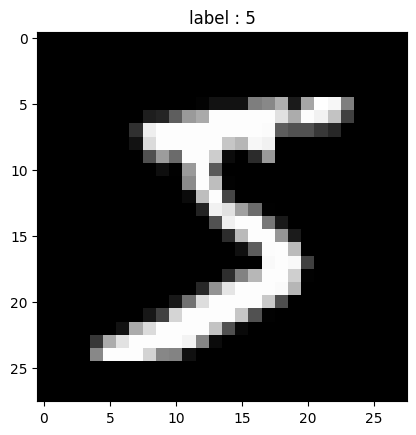

In [5]:
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap='gray')    # cmap defulat : viridis
# image.squeeze() : 크기가 1인 차원 없애줌 ([1,28,28]>[28,28])
plt.title('label : %s' % label)
plt.show()

### 2-3. 미니 배치 구성하기

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

# 6만개 학습 데이터, 배치 사이즈 50 -> 배치 개수 1200
# fist_batch[0] : 미니 배치 텐서
# first_batch[1] : 미니 배치 레이블

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


## 3. 모델 학습

### 3-1. CNN 구조 설계하기

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()            # nn.Module 클래스의 속성을 상속받고 초기화
        self.conv1    = nn.Conv2d(1, 32, 3, 1) # in_channels, out_channels, kernel_size, stride
        self.conv2    = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1      = nn.Linear(9216, 128)
        self.fc2      = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # (2x2) 크기의 filter로 max pooling 적용
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)    # softmax대신 log_softmax 사용시 연산 속도 높임
        return output

### 3-2. Optimizer 및 손실 함수 정의

In [14]:
model     = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()   # 손실 함수

### 3-3. 설계한 CNN 모형 확인하기

In [15]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### 3-4. 모델 학습

In [18]:
# model을 학습 모드로 실행
model.train()

i = 0

for epoch in range(epoch_num):
    for data, target in train_loader:
        data   = data.to(device)
        target = target.to(device)
        # 학습 시작 전, grad 초기화
        optimizer.zero_grad()
        output = model(data)
        # 50개의 배치마다 1개의 loss 계산
        loss   = criterion(output, target)
        # 손실함수 통해 grad 계산
        loss.backward()
        # 가중치 업데이트
        optimizer.step()
        
        if i % 1000 == 0:
            print('Train Step: {} \t Loss: {:.3f}'.format(i, loss.item()))
            
        i += 1

/opt/homebrew/lib/python3.11/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Step: 0 	 Loss: 0.252
Train Step: 1000 	 Loss: 0.229
Train Step: 2000 	 Loss: 0.220
Train Step: 3000 	 Loss: 0.049
Train Step: 4000 	 Loss: 0.094
Train Step: 5000 	 Loss: 0.104
Train Step: 6000 	 Loss: 0.036
Train Step: 7000 	 Loss: 0.026
Train Step: 8000 	 Loss: 0.063
Train Step: 9000 	 Loss: 0.059
Train Step: 10000 	 Loss: 0.034
Train Step: 11000 	 Loss: 0.024
Train Step: 12000 	 Loss: 0.097
Train Step: 13000 	 Loss: 0.026
Train Step: 14000 	 Loss: 0.010
Train Step: 15000 	 Loss: 0.026
Train Step: 16000 	 Loss: 0.030
Train Step: 17000 	 Loss: 0.116


#### 모델 평가

In [28]:
# 모델 학습을 마쳤다면, 테스트 데이터를 통해 모델 성능 평가

# 평가 모드 실행 (dropout 적용 X. batch normalization도 평가 모드로 전환)
''' cf) 배치정규화의 eval
    model.eval()를 호출하면 배치 정규화 레이어가 더 이상 현재 배치의 통계를 사용하지 않고, 훈련 과정에서 계산된 통계를 사용하여 정규화하게 됩니다. 이를 통해 훈련 중에 학습된 통계를 기반으로 예측이 이루어집니다.
'''
model.eval()
# 정답 개수 초기화
correct = 0     
for data, target in test_loader:
    data        = data.to(device)
    target      = target.to(device)
    output      = model(data)
    prediction  = output.max(1)[1] # 값이 가장 큰 인덱스를 prediction으로 저장
    # output.max(1) : output(batch_size x num_classes)에서 두 번째 차원(클래스차원)에서 최댓값 찾기
    # output.max(1) 반환 _ 1. 각 배치에 대해 가장 큰 값(확률), 2. 그 값이 위치한 인덱스 (클래스번호)
    correct    += prediction.eq(target).sum()

print('Test set: Accuracy: {:.2f}%'.format(100 * correct / len(test_loader.dataset)))
# len(test_loader.dataset): 테스트 데이터셋 전체의 샘플 수를 반환
# len(test_loader): 테스트 로더의 배치 수를 반환

/opt/homebrew/lib/python3.11/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test set: Accuracy: 99.02%
